Active cells created from topography!
covariance:  [[[0.0002]]

 [[0.0008]]]


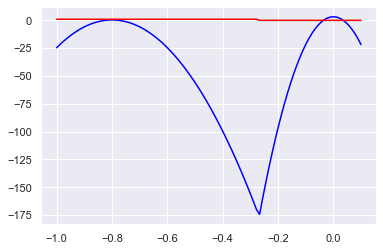

In [1]:
"""

Script of petro-inversion of gravity over TKC

Notes:
This version of the script uses data with less noises
but still invert with a higher assumed noise level.
This is equivalent to increase the chi-factor.
This has been needed in order to fit both geophysical
and petrophysical data set.
"""

# Script of petro-inversion of gravity over TKC
import SimPEG.PF as PF
from SimPEG import *
from SimPEG.Utils import io_utils
import matplotlib
import time as tm
import mpl_toolkits.mplot3d as a3
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import scipy as sp
from scipy.interpolate import NearestNDInterpolator
from sklearn.mixture import GaussianMixture
import numpy as np
import copy
from pymatsolver import PardisoSolver
%matplotlib inline
matplotlib.rcParams['font.size'] = 14
import seaborn
seaborn.set()
# Reproducible Science
np.random.seed(518936)

# We first need to create a susceptibility model.
# Based on a set of parametric surfaces representing TKC,
# we use VTK to discretize the 3-D space.

# Reproducible Science
np.random.seed(518936)

# We first need to create a susceptibility model.
# Based on a set of parametric surfaces representing TKC,
# we use VTK to discretize the 3-D space.

mesh = Mesh.load_mesh('C:/Users/Thibaut Astic/Dropbox/PhD_UBC/TKC_Joint_SEG_abstract_example/Forward and Operators/mesh_inverse')

# Define no-data-value
ndv = -100

# Define survey flight height
Z_bird = 2.

# Load topography file in UBC format and find the active cells
# Import Topo
model_dir = 'C:/Users/Thibaut Astic/Dropbox/PhD_UBC/TKC_Joint_SEG_abstract_example/Geological_model/'
topofile = model_dir + 'TKCtopo.dat'
topo = np.genfromtxt(topofile, skip_header=1)
# Find the active cells
actv = Utils.surface2ind_topo(mesh, topo, gridLoc='N')
# Create active map to go from reduce set to full
actvMap = Maps.InjectActiveCells(mesh, actv, ndv)
print("Active cells created from topography!")

# Load data
survey = io_utils.readUBCgravityObservations(
    "C:/Users/Thibaut Astic/Dropbox/PhD_UBC/TKC_Joint_SEG_abstract_example/Forward and Operators/GRAV_CoarseForward_DoubleContrast_Synthetic_data_noisy.obs"
)

# Now that we have a survey we can build the linear system ...
nactv = np.int(np.sum(actv))
# Creat reduced identity map
idenMap = Maps.IdentityMap(nP=nactv)
# Create the forward model operator
prob = PF.Gravity.GravityIntegral(mesh, rhoMap=idenMap, actInd=actv)
# Pair the survey and problem
survey.pair(prob)

G = np.load('C:/Users/Thibaut Astic/Dropbox/PhD_UBC/TKC_Joint_SEG_abstract_example/Forward and Operators/G_Grav_Inverse.npy')
prob._G = - G


# We add some random Gaussian noise
std = 0.01
#survey.dobs += std * np.random.randn(len(survey.dobs))
survey.eps = 0.

# **Inverse problem**

# Petro Inversion

# It is potential fields, so we will need to push the inverison down
# Create distance weights from our linera forward operator
# rxLoc = survey.srcField.rxList[0].locs
# wr = PF.Magnetics.get_dist_wgt(mesh, rxLoc, actv, 3., np.min(mesh.hx)/4.)
# wr = wr**2.
wr = np.sum(prob.G**2., axis=0)**0.5
wr = (wr / np.max(wr))

m0 = np.ones(idenMap.nP) * -1e-4

# Define Petrophysics
mesh_forward = Mesh.load_mesh('C:/Users/Thibaut Astic/Dropbox/PhD_UBC/TKC_Joint_SEG_abstract_example/Forward and Operators/mesh_forward_v2')
model_grav = mesh_forward.readModelUBC(
    'C:/Users/Thibaut Astic/Dropbox/PhD_UBC/TKC_Joint_SEG_abstract_example/Forward and Operators/Synthetic_Grav_forward.den'
)
geomodel = mesh.readModelUBC(
    'C:/Users/Thibaut Astic/Dropbox/PhD_UBC/TKC_Joint_SEG_abstract_example/Forward and Operators/geomodel_inverse_reduced'
) 
model_grav = model_grav[model_grav != -100.]
n = 2
weights_init = np.r_[
    np.count_nonzero(geomodel[mesh.vol==mesh.vol.min()] == 0.),
    np.count_nonzero(geomodel[mesh.vol==mesh.vol.min()] == 1.)+ np.count_nonzero(geomodel[mesh.vol==mesh.vol.min()] == 2.),
]/len(geomodel[np.logical_and(mesh.vol==mesh.vol.min(),geomodel!=-100.)])
means_init = np.array([0., -0.8,]).reshape(n, 1)
cov_init = np.array(
    [[2.*1e-4],
     #[((2. * 1e-2)**2.)],
     [8e-4]]).reshape((n, 1, 1))
# cov_init = np.array([[(1. * 1e-2)**2.]])
# samples = copy.deepcopy(m_true[actv])
# samples[samples == -.4] = np.ones_like(samples)[samples == -.4] * (-0.1)
meshweights = copy.deepcopy(mesh)
meshweights._vol = meshweights.vol[actv]
clf = Utils.WeightedGaussianMixture(
    mesh = meshweights,
    n_components=n,
    covariance_type='full',
    reg_covar=1e-7,
    means_init=means_init,
    precisions_init=np.linalg.inv(cov_init),
    n_init=1,
    max_iter=100,
    tol=1e-3,
    init_params='random'
)
clf.fit(m0.reshape(-1, 1))
Utils.order_clusters_GM_weight(clf)
clf.weights_ = weights_init
clf.means_ = means_init
clf.covariances_ = cov_init
clf.precisions_cholesky_ = Utils._compute_precision_cholesky(
    clf.covariances_, clf.covariance_type
)
Utils.computePrecision(clf)
Utils.order_clusters_GM_weight(clf)

print('covariance: ', clf.covariances_)
vmin, vmax = -1.,0.1
plt.plot(
     np.linspace(vmin, vmax, 100), (
         clf.score_samples(np.linspace(vmin, vmax, 100)[:, np.newaxis])
     ),
     color='blue'
)
plt.plot(
     np.linspace(vmin, vmax, 100), (
         clf.predict(np.linspace(vmin, vmax, 100)[:, np.newaxis])
     ),
     color='red'
)
#plt.gca().set_ylim([-10.,10.])
plt.show()

wires = Maps.Wires(('m', m0.shape[0]))
reg = Regularization.MakeSimplePetroRegularization(
    GMmref=clf,
    GMmodel=clf,
    mesh=mesh,
    wiresmap=wires,
    maplist=[idenMap],
    mref=m0,
    indActive=actv,
    alpha_s=1.0, alpha_x=1.0, alpha_y=1.0, alpha_z=1.0,
    alpha_xx=0., alpha_yy=0., alpha_zz=0.,
    cell_weights_list=[wr]
)
# reg = Regularization.SimplePetroRegularization(
#     GMmref=clf,
#     GMmodel=clf,
#     mesh=mesh,
#     wiresmap=wires,
#     maplist=[idenMap],
#     mref=m0,
#     indActive=actv
# )
# reg.objfcts[0].cell_weights = wr
dmis = DataMisfit.l2_DataMisfit(survey)
# Assign flat uncertainties of 0.01mGal
wd = np.ones(len(survey.dobs)) * 0.01
dmis.W = 1 / wd

reg.mrefInSmooth = False
reg.approx_gradient = True
reg.objfcts[0].evaltype = 'approx'
gamma_petro = np.ones(n)*1e8
reg.objfcts[0].gamma = gamma_petro

# Add directives to the inversion
# opt = Optimization.InexactGaussNewton(maxIter=30)
opt = Optimization.ProjectedGNCG(
    maxIter=30, lower=-2., upper=0., maxIterLS=20, maxIterCG=100, tolCG=1e-4
)
invProb = InvProblem.BaseInvProblem(dmis, reg, opt)

Alphas = Directives.AlphasSmoothEstimate_ByEig(
    alpha0_ratio=0.5,
    ninit=10, verbose=True
)
beta = Directives.BetaEstimate_ByEig(beta0_ratio=1., ninit=10)
betaIt = Directives.PetroBetaReWeighting(
    verbose=True, rateCooling=5., rateWarming=1.,
    tolerance=0.1, UpdateRate=1,
    ratio_in_cooling=False,
    progress=0.2,
    update_prior_confidence=False,
    progress_gamma_cooling=1.,
    ratio_in_gamma_cooling=False,
    alphadir_rateCooling=1.,
    kappa_rateCooling=1.,
    nu_rateCooling=1.,
)
targets = Directives.PetroTargetMisfit(verbose=True)
MrefInSmooth = Directives.AddMrefInSmooth(
    wait_till_stable=True,
    verbose=True
)
petrodir = Directives.GaussianMixtureUpdateModel(
    keep_ref_fixed_in_Smooth=True,
    verbose=False,
    nu=1e8,
    kappa=1e8,
    alphadir=1e8
)
update_Jacobi = Directives.UpdatePreconditioner()

inv = Inversion.BaseInversion(
    invProb,
    directiveList=[
        Alphas, beta,
        petrodir, targets,
        betaIt, MrefInSmooth, update_Jacobi
    ]
)

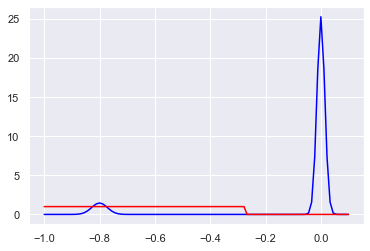

In [2]:
plt.plot(
     np.linspace(vmin, vmax, 100), np.exp(
         clf.score_samples(np.linspace(vmin, vmax, 100)[:, np.newaxis])
     ),
     color='blue'
)
plt.plot(
     np.linspace(vmin, vmax, 100), (
         clf.predict(np.linspace(vmin, vmax, 100)[:, np.newaxis])
     ),
     color='red'
)
#plt.gca().set_ylim([-10.,10.])
plt.show()

In [3]:
# Run inversion...
mcluster = inv.run(m0)


                SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                ***Done using same Solver and solverOpts as the problem***
Alpha scales:  [1, 1]
Alpha scales:  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Alpha scales:  [0.0, 6436.229106321939, 6418.893133076674, 6426.954243188135]
Approximated diag(JtJ) with linear operator
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.53e+01  4.32e+06  0.00e+00  4.32e+06    1.22e+03      0              
DM:  [960349.1679746] [False] ; CL:  1494330.942796149 False ; DP:  True ; All: False
progress [960349.1679746] >< [3453239.3397073]
mref changes in  0  places
   1  1.53e+01  9.60e+05  4.28e+04  1.62e+06    9.53e+01      0              
DM:  [968136.00321939] [False] ; CL:  1471923.8896508

In [4]:
dmis(mcluster)

341.90505464710384

In [5]:

# Get the final model back to full space
m_petro = actvMap * mcluster
m_petro[m_petro == ndv] = np.nan
# Save both models to file
Mesh.TensorMesh.writeModelUBC(
    mesh,
    'SimPEG_GRAV_petro_Inversion_crime_onlyPKVK.den',
    m_petro
)

import pickle
pickle.dump(reg.objfcts[0].GMmodel, open(
    "clfinv_grav_petro_Inversion_crime_onlyPKVK.p", "wb"))

ValueError: cannot reshape array of size 1488400 into shape (100,121,121)

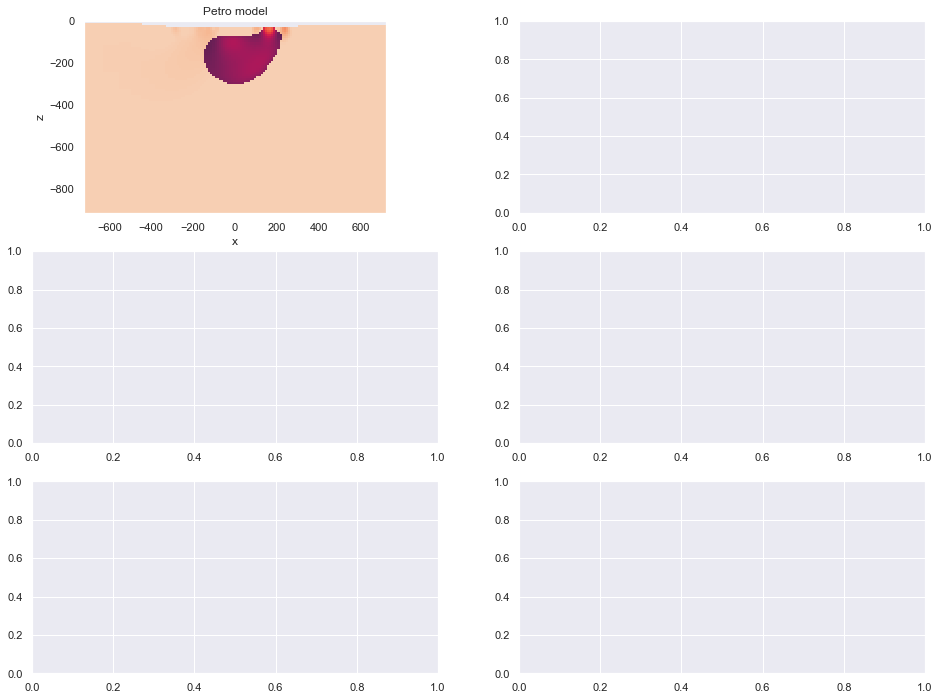

In [6]:
# Plot the recoverd models
mesh = Mesh.TensorMesh([mesh.hx, mesh.hy, mesh.hz], x0="CCN")
npad = 10
X, Y = np.meshgrid(mesh.vectorCCx[npad:-npad:2], mesh.vectorCCy[npad:-npad:2])

vmin, vmax = -1.2, 0.1
fig, ax = plt.subplots(3, 2, figsize=(16, 12))
ax = Utils.mkvc(ax)
mesh.plotSlice(
    m_petro, ax=ax[0], normal='Y',
    clim=np.r_[vmin, vmax]
)
ax[0].set_aspect('equal')
ax[0].set_title('Petro model')

mesh_forward = Mesh.load_mesh('C:/Users/Thibaut Astic/Dropbox/PhD_UBC/TKC_Joint_SEG_abstract_example/Forward and Operators/mesh_forward')
model_grav = mesh_forward.readModelUBC(
    'C:/Users/Thibaut Astic/Dropbox/PhD_UBC/TKC_Joint_SEG_abstract_example/Forward and Operators/Synthetic_Grav_forward.den'
)
dat_true = mesh_forward.plotSlice(
    model_grav, ax=ax[1], normal='Y',
    clim=np.r_[vmin, vmax]
)
ax[1].set_aspect('equal')
ax[1].set_title('True model')

pos = ax[1].get_position()
cbarax = fig.add_axes(
    [pos.x0 - 0.15, pos.y0,  pos.width * 0.1, pos.height * 0.75]
)  # the parameters are the specified position you set
cb = fig.colorbar(
    dat_true[0], cax=cbarax, orientation="vertical",
    ax=ax[1], ticks=np.linspace(vmin, vmax, 4)
)
mcluster = m_petro[~np.isnan(m_petro)]
ax[2].hist(mcluster, bins=100, normed=True)
ax[2].plot(
    np.linspace(vmin, vmax, 100), np.exp(
        clf.score_samples(np.linspace(vmin, vmax, 100)[:, np.newaxis])
    ),
    color='blue'
)
ax[2].plot(
    np.linspace(vmin, vmax, 100), np.exp(
        reg.objfcts[0].GMmodel.score_samples(np.linspace(vmin, vmax, 100)[:, np.newaxis])
    ),
    color='k'
)
ax[2].set_ylim([0., 5.])

gmin, gmax = np.min(survey.dobs), np.max(survey.dobs)
d2D = survey.dobs.reshape(X.shape)
dat = ax[3].contourf(X, Y, d2D, vmin=gmin, vmax=gmax)
ax[3].set_aspect('equal')
ax[3].plot(X.flatten(), Y.flatten(), 'k.', ms=2)
ax[3].set_xlabel("Easting (m)")
ax[3].set_ylabel("Northing (m)")
ax[3].set_title("Data (mGal)")
ax[3].set_xlim(-500, 500)
ax[3].set_ylim(-500, 500)

pos = ax[3].get_position()
cbarax = fig.add_axes(
    [pos.x0 + 0.3, pos.y0 + 0.1,  pos.width * 0.1, pos.height * 0.75]
)  # the parameters are the specified position you set
cb = fig.colorbar(
    dat, cax=cbarax, orientation="vertical",
    ax=ax[3], ticks=np.linspace(gmin, gmax, 6)
)

dpred = prob.fields(mcluster)
d2D = dpred.reshape(X.shape)
dat = ax[4].contourf(X, Y, d2D, vmin=gmin, vmax=gmax)
ax[4].set_aspect('equal')
ax[4].plot(X.flatten(), Y.flatten(), 'k.', ms=2)
ax[4].set_xlabel("Easting (m)")
ax[4].set_ylabel("Northing (m)")
ax[4].set_title("Dpred (mGal)")
ax[4].set_xlim(-500, 500)
ax[4].set_ylim(-500, 500)

# pos = ax[4].get_position()
# cbarax = fig.add_axes(
#     [pos.x0+0.3 , pos.y0,  pos.width*0.1, pos.height*0.75]
# )  # the parameters are the specified position you set
# cb = fig.colorbar(
#     dat,cax=cbarax, orientation="vertical",
#     ax=ax[4],ticks=np.linspace(gmin,gmax, 6)
# )

misfit = (survey.dobs - dpred) / std
d2D = misfit.reshape(X.shape)
dat = ax[5].contourf(X, Y, d2D)
ax[5].set_aspect('equal')
ax[5].plot(X.flatten(), Y.flatten(), 'k.', ms=2)
ax[5].set_xlabel("Easting (m)")
ax[5].set_ylabel("Northing (m)")
ax[5].set_title("Misfit")
ax[5].set_xlim(-500, 500)
ax[5].set_ylim(-500, 500)

pos = ax[5].get_position()
cbarax = fig.add_axes(
    [pos.x0 + 0.3, pos.y0,  pos.width * 0.1, pos.height * 0.75]
)  # the parameters are the specified position you set
cb = fig.colorbar(
    dat, cax=cbarax, orientation="vertical",
    ax=ax[5],
)
plt.tight_layout()
#fig.savefig(
#    'PF_AllUnits_with_jacobi_less_noise_no_Inversion_crime.png',
#    dpi=150
#)
plt.show()


In [ ]:
reg.objfcts[0].GMmodel.weights_

In [ ]:
weights_init

In [ ]:
weights_init_2 = np.r_[
    np.count_nonzero(geomodel == 0.),
    np.count_nonzero(geomodel == 1.)+ np.count_nonzero(geomodel == 2.),
]/len(geomodel[geomodel!=-100.])
n = 2
means_init = np.array([0., -0.8,]).reshape(n, 1)
cov_init = np.array(
    [[2.*1e-4],
     #[((2. * 1e-2)**2.)],
     [((2.*2. * 1e-2)**2.)]]).reshape((n, 1, 1))
# cov_init = np.array([[(1. * 1e-2)**2.]])
# samples = copy.deepcopy(m_true[actv])
# samples[samples == -.4] = np.ones_like(samples)[samples == -.4] * (-0.1)
meshweights = copy.deepcopy(mesh)
meshweights._vol = meshweights.vol[actv]
clf2 = Utils.WeightedGaussianMixture(
    mesh = meshweights,
    n_components=n,
    covariance_type='full',
    reg_covar=1e-7,
    means_init=means_init,
    precisions_init=np.linalg.inv(cov_init),
    n_init=1,
    max_iter=100,
    tol=1e-3,
    init_params='random'
)
clf2.fit(m0.reshape(-1, 1))
Utils.order_clusters_GM_weight(clf2)
clf2.weights_ = weights_init_2
clf2.means_ = means_init
clf2.covariances_ = cov_init
clf2.precisions_cholesky_ = Utils._compute_precision_cholesky(
    clf2.covariances_, clf2.covariance_type
)
Utils.computePrecision(clf2)
Utils.order_clusters_GM_weight(clf2)

print('covariance: ', clf2.covariances_)

In [ ]:
weights_init_2

In [ ]:
plt.plot(
     np.linspace(vmin, vmax, 100), np.exp(
         clf2.score_samples(np.linspace(vmin, vmax, 100)[:, np.newaxis])
     ),
     color='blue'
)
plt.plot(
     np.linspace(vmin, vmax, 100), (
         clf2.predict(np.linspace(vmin, vmax, 100)[:, np.newaxis])
     ),
     color='red'
)
plt.plot(
     np.linspace(vmin, vmax, 100), np.exp(
         clf.score_samples(np.linspace(vmin, vmax, 100)[:, np.newaxis])
     ),
     color='black'
)
plt.plot(
     np.linspace(vmin, vmax, 100), (
         clf.predict(np.linspace(vmin, vmax, 100)[:, np.newaxis])
     ),
     color='black'
)
#plt.gca().set_ylim([-10.,10.])
plt.show()

In [ ]:
weights_init_2.sum()